# 23.11.03 ViT test for Platn leaf disese detection/classification

## Data augmentation
- STEP2(Disease detection)는 10도씩 36배
    - 정상사진이 있어 데이터셋 커보이지만 실제로는 작물별로 CNN분석했기 때문에 많지 않다
- STEP3(Disease classification)는 10도씩 36배
    - 병징사진만 있으므로 36배

In [18]:
# Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os

# 11.14 additional setup
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import cv2
import os
import matplotlib.pyplot as plt
import time

from keras import Input, optimizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras import layers
from keras.applications import ResNet50, DenseNet201, VGG19
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from random import sample
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, MaxPooling2D, Dropout, Flatten, concatenate
from keras.models import Sequential
from sklearn.metrics import precision_score, recall_score, f1_score

### GPU 할당

In [2]:
###################
# GPU 있는지 확인 #
###################

# REF: https://lungfish.tistory.com/entry/딥러닝-텐서플로우-GPU-확인-및-사용하기 [물 만날 물고기:티스토리]

import os
import tensorflow as tf 
import torch
from tensorflow.python.client import device_lib

print('Tensorflow version:', tf.__version__)
# print(tf.debugging.set_log_device_placement(True)) 
    # debugging log 뜨는데 이게 학습에 방해를 함
    # https://stackoverflow.com/questions/64961303/suppress-tensorflow-executing-op-messages-when-using-tpu
print()
##############################################################################
print('torch cudnn version:', torch.backends.cudnn.version())
print()
##############################################################################
print('device_lib.list:', device_lib.list_local_devices())

Tensorflow version: 2.11.0

torch cudnn version: 8500

device_lib.list: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6716434685049770297
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48969285632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2311421128563435192
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-12-08 14:15:02.043991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 14:15:04.449248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 46700 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [3]:
print('device_lib.list [1]:', device_lib.list_local_devices()[1])

device_lib.list [1]: name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 48969285632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2133293049438344962
physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6"
xla_global_id: 416903419



2023-12-08 14:15:10.249135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 46700 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [4]:
###########################
# GPU 사용하도록 불러오기 #
###########################

# import logging, os
# ###############################################################################################################
# tf.get_logger().setLevel(logging.ERROR)  # ERROR 레벨 이상의 메시지만 표시
# ###############################################################################################################

# ###############################################################################################################

# class FilterOutExecutingOp(logging.Filter):
#     def filter(self, record):
#         return "Executing op" not in record.getMessage()

# tf.get_logger().addFilter(FilterOutExecutingOp())
# ###############################################################################################################

# ###############################################################################################################
# tf.config.run_functions_eagerly(False)
# ###############################################################################################################

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# tensorflow가 gpu를 잡고있는지 확인
# GPU가 나오면됨
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# 주로 사용하는 코드 2 : 인식한 GPU 개수 출력
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### 파일명 변경 

In [3]:
FILE_PATH_DICT = {'Potato_Healthy_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/00_STEP3_Potato_Healthy', 
                  'Potato_Early_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/01_STEP3_Potato_Early_blight',
                  'Potato_Late_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/02_STEP3_Potato_Late_blight', 
                  'Tomato_Healthy_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/00_STEP3_Tomato_Healthy',
                  'Tomato_Early_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/01_STEP3_Tomato_Early_blight', 
                  'Tomato_Late_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/02_STEP3_Tomato_Late_blight',
                  'Tomato_Bacterial_spot_file_path' :'/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/03_STEP3_Tomato_Bacterial_spot',
                  'Tomato_Tomato_mosaic_virus_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/04_STEP3_Tomato_Tomato_mosaic_virus'}


for i in FILE_PATH_DICT:
    list_dir = os.listdir(FILE_PATH_DICT[i])
    len_list_dir = len(list_dir)
    print(len_list_dir)
    
    
    num = 0
    
    for j in list_dir:
        print(j)
        a = j.split('___')[-1].split(' ')
        
        a.insert(0,str(num))
        a.insert(1, i[:14])
        print(a)
        
        b = '_'.join(a)
        print(b)
        
        os.rename(FILE_PATH_DICT[i] + '/' + j, FILE_PATH_DICT[i] + '/' +b)    
        
        num += 1


155
d227e4c8-e203-4aa4-b813-25b96baa2869___RS_HL 1831_final_masked.jpg
['0', 'Potato_Healthy', 'RS_HL', '1831_final_masked.jpg']
0_Potato_Healthy_RS_HL_1831_final_masked.jpg
a02b6205-b40a-4178-8b34-3494f84b9d1f___RS_HL 1958_final_masked.jpg
['1', 'Potato_Healthy', 'RS_HL', '1958_final_masked.jpg']
1_Potato_Healthy_RS_HL_1958_final_masked.jpg
5ea316eb-10a2-42c0-b781-40d90356ccaa___RS_HL 1935_final_masked.jpg
['2', 'Potato_Healthy', 'RS_HL', '1935_final_masked.jpg']
2_Potato_Healthy_RS_HL_1935_final_masked.jpg
b28c43f9-5844-4e9b-86bf-36bc114cae07___RS_HL 1736_final_masked.jpg
['3', 'Potato_Healthy', 'RS_HL', '1736_final_masked.jpg']
3_Potato_Healthy_RS_HL_1736_final_masked.jpg
9a6eb7c4-6b43-477a-89e0-69f62ef67991___RS_HL 1846_final_masked.jpg
['4', 'Potato_Healthy', 'RS_HL', '1846_final_masked.jpg']
4_Potato_Healthy_RS_HL_1846_final_masked.jpg
a8d687be-3777-403f-bae7-5c8c19340b3f___RS_HL 1738_final_masked.jpg
['5', 'Potato_Healthy', 'RS_HL', '1738_final_masked.jpg']
5_Potato_Healthy_RS_H

6f211a42-cdd8-4c5c-89b3-17e50f324621___GCREC_Bact.Sp 3569_final_masked.jpg
['30', 'Tomato_Bacteri', 'GCREC_Bact.Sp', '3569_final_masked.jpg']
30_Tomato_Bacteri_GCREC_Bact.Sp_3569_final_masked.jpg
e2c80b64-2520-49c4-bedc-a604355be09b___GCREC_Bact.Sp 3609_final_masked.jpg
['31', 'Tomato_Bacteri', 'GCREC_Bact.Sp', '3609_final_masked.jpg']
31_Tomato_Bacteri_GCREC_Bact.Sp_3609_final_masked.jpg
3c182852-8b72-465a-ad91-a031d9d725f5___UF.GRC_BS_Lab Leaf 0411_final_masked.jpg
['32', 'Tomato_Bacteri', 'UF.GRC_BS_Lab', 'Leaf', '0411_final_masked.jpg']
32_Tomato_Bacteri_UF.GRC_BS_Lab_Leaf_0411_final_masked.jpg
4d33be8c-151b-4d2b-960f-f15ef077d4cc___GCREC_Bact.Sp 3767_final_masked.jpg
['33', 'Tomato_Bacteri', 'GCREC_Bact.Sp', '3767_final_masked.jpg']
33_Tomato_Bacteri_GCREC_Bact.Sp_3767_final_masked.jpg
c92d6418-adbe-430d-9dcd-bf432490abf5___GCREC_Bact.Sp 3233_final_masked.jpg
['34', 'Tomato_Bacteri', 'GCREC_Bact.Sp', '3233_final_masked.jpg']
34_Tomato_Bacteri_GCREC_Bact.Sp_3233_final_masked.jpg
42

In [4]:
for i in FILE_PATH_DICT:
    list_dir = os.listdir(FILE_PATH_DICT[i])
    len_list_dir = len(list_dir)
    print(FILE_PATH_DICT[i], len_list_dir)

/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/00_STEP3_Potato_Healthy 155
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/01_STEP3_Potato_Early_blight 929
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/02_STEP3_Potato_Late_blight 734
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/00_STEP3_Tomato_Healthy 1217
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/01_STEP3_Tomato_Early_blight 302
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/02_STEP3_Tomato_Late_blight 467
/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/03_STEP3_Tomato_Bacterial_spot 1682
/BiO/Sangjin_Ko_work_2022/16_Vision

### 파일 augmentation

In [6]:
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps

In [8]:
# input 파일 경로 딕셔너리화

input_file_dict = {'Potato_Healthy_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/00_STEP3_Potato_Healthy', 
                  'Potato_Early_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/01_STEP3_Potato_Early_blight',
                  'Potato_Late_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Potato_all/02_STEP3_Potato_Late_blight', 
                  'Tomato_Healthy_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/00_STEP3_Tomato_Healthy',
                  'Tomato_Early_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/01_STEP3_Tomato_Early_blight', 
                  'Tomato_Late_blight_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/02_STEP3_Tomato_Late_blight',
                  'Tomato_Bacterial_spot_file_path' :'/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/03_STEP3_Tomato_Bacterial_spot',
                  'Tomato_Tomato_mosaic_virus_file_path' : '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_AUGMENTED_STEP3_Dataset/STEP3_Tomato_all/04_STEP3_Tomato_Tomato_mosaic_virus'}


# output path 생성
output_folder_path_list = [
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Potato_all/00_STEP3_Potato_Healthy',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Potato_all/01_STEP3_Potato_Early_blight',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Potato_all/02_STEP3_Potato_Late_blight',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Tomato_all/00_STEP3_Tomato_Healthy',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Tomato_all/01_STEP3_Tomato_Early_blight',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Tomato_all/02_STEP3_Tomato_Late_blight',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Tomato_all/03_STEP3_Tomato_Bacterial_spot',
     '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_TEMP_STEP3_Dataset/STEP3_Tomato_all/04_STEP3_Tomato_Tomato_mosaic_virus',
]


# Datat augmentation
def rotate_and_save(input_path, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True) # exist_ok라는 파라미터를 True로 하면 해당 디렉토리가 기존에 존재하면 에러발생 없이 넘어가고, 없을 경우에만 생성합니다.

    # Open the image
    with Image.open(input_path) as img:
        # Rotate and save the image for each angle
        for angle in range(0, 360, 20):
            rotated_img = img.rotate(angle)
            output_path = os.path.join(output_folder, input_path.split('/')[-1] + f"rotated_{angle}.jpg")
            rotated_img.save(output_path)


# if __name__ == "__main__": # 해당 구문이 사용된 파이썬 파일을 직접 실행했을 때만 아래 코드를 실행하겠다

# input 사진 listup, output_folder_path 지정
num = 0

for h in input_file_dict.values():
    input_file_list = os.listdir(h)
    print('input_file_list:', len(input_file_list))

    output_folder_path = output_folder_path_list[num]

    # 사진별 rotate 실행
    for i in input_file_list:
        rotate_and_save(h + '/' + i, output_folder_path)

    num += 1

input_file_list: 155
input_file_list: 929
input_file_list: 733
input_file_list: 1217
input_file_list: 302
input_file_list: 467
input_file_list: 1682
input_file_list: 281


## ViT script
- An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale 논문 기반
- REF: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
# # This example requires TensorFlow 2.4 or higher, as well as TensorFlow Addons, which can be installed using the following command:

# %pip install -U tensorflow-addons
# %pip install xlsxwriter

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## STEP2) Disease detection for individual crops
#### (Step2; step1은 crop detection으로 패스)

- Tree individual models were developed to detect disease for bell pepper,
potato, and tomato.

- **Bell pepper** disease detection model:
    - Train & Validation(80%) :
        - 1,165 healthy images
        - 746 diseased images
    - Test(20%) :
        - 291 *(1,456-1,165)* healthy images
        - 187 *(933-746)* diseased images

- **Potato** disease detection model:
    - Train & Validation(80%) :
        - 118 healthy images
        - 1,330 diseased images
    - Test(20%) :
        - 30 *(148-118)* healthy images
        - 332 *(1662-1330)* diseased images

- **Tomato** disease detection model:
    - Train & Validation(80%) :
        - 974 healthy images,
        - 2,176 diesased images
            - bacterial spot: 1,670
            - early blight: 302
            - late blight: 467
            - mosaic virus: 281
    - Test(20%) :
        - 243 *(1,217-974)* healthy images
        - 544 *(2,720-2,176)* diseased images

### (공통)Configure hyperparameter

In [16]:
# Configure the hyperparameters

# Basic parameter
Ratio_val_set = 0.2
Ratio_test_set = 0.2
iter = 3

# v2 기준 parameter
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H:%M:%S") #ref : https://dev-jy.tistory.com/5
# es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5) # early stop을 걸어야 할까?

# leaf classification v2 원본(CNN model 5개 비교하는 일 했으므로 (iter, 5)로 해둠)
# result_acc = np.zeros(shape=(iter, 5))
# result_val_acc = np.zeros(shape=(iter, 5))
# result_precision=np.zeros(shape=(iter, 5))
# result_recall=np.zeros(shape=(iter, 5))
# result_f1=np.zeros(shape=(iter, 5))

result_acc = np.zeros(shape=(iter, 1))
result_val_acc = np.zeros(shape=(iter, 1))
result_precision=np.zeros(shape=(iter, 1))
result_recall=np.zeros(shape=(iter, 1))
result_f1=np.zeros(shape=(iter, 1))

# 저장용 폴더 생성
folder = '/002_18_AUGMENTED_STEP3_Dataset-analysis-RESULT'

if not (os.path.isdir('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder )):
    os.makedirs('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder)

writer = pd.ExcelWriter('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Disease_classification_result_'+ str(now) + '.xlsx', engine='xlsxwriter')


# 분류 class 개수 (cifar-100 dataset 사용하므로)
num_classes = 4 # Healthy or Disease 이므로

# input 사진 크기
input_shape = (256, 256, 3)

# 학습률
learning_rate = 0.001

# 가중치 감소
weight_decay = 0.0001
    # Weight_decay = 가중치 감소
    # ref: http://www.gisdeveloper.co.kr/?p=8443
    # 오버피팅을 해소하기 위해 특정값을 손실함수에 더해 주는 것
    # weight_decay 값이 클 수록 가중치 값이 적어져 오버피팅을 해소할 수 있지만,
    # weight decay 값을 너무 크게하면 언더피팅현상이 발생할 수 있다

# batch : batch 마다 나눠진 데이터 셋의 size 뜻함 데이터 샘플의 size
batch_size = 2
    # ref: https://m.blog.naver.com/qbxlvnf11/221449297033

# epoch : 전체 데이터셋 학습 횟수
num_epochs = 100
    # ref: https://m.blog.naver.com/qbxlvnf11/221449297033

# iteration : epoch를 나눠 실행하는 횟수

    # 메모리의 한계와 속도 저하 떄문에 한번의 epoch에서 모든 데이터 넣을 수 없다
    # 따라서 데이터를 나눠서 주게 되는데 이때 몇 번 나누는가를 iteration,
    # iteration 마다 주는 데이터 사이즈를 batch size라고 한

image_size = 128  # We'll resize input images to this size

# patch_size
patch_size = 8  # Size of the patches to be extract from the input images
    # image를 patch size 크기의 픽셀 단위로 자름

num_patches = (image_size // patch_size) ** 2

# 원본 projection dimension (차원 축소 )
projection_dim = 64
    # ref: chat gpt
    # 신경망에 입력된 데이터를 저차원 벡터로 매핑하는 층을 가지는 이때 저차원 벡터의 크기나 차원을 말함


num_heads = 4

# 원본
# transformer_units = [projection_dim * 2,projection_dim,]  # Size of the transformer layers

transformer_units = [projection_dim * 2, projection_dim,]  # Size of the transformer layers

transformer_layers = 8

# 원본
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier

### 폴더 별 데이터 분리

In [8]:
# # google drive에서 raw data 업로드
# from google.colab import drive
# drive.mount('/content/drive')


# # 분류 class 개수
# num_classes = 4 # Normal or Disease 이므로

# # input 사진 크기
# input_shape = (256, 256, 3)

# Potato_folder = '/STEP3_RE_NAME_AUGMENTATION_Tomato_all'
Tomato_folder = '/STEP3_RE_NAME_AUGMENTATION_Tomato_all'


# Potato_dataset_path = '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_18_AUGMENTED_STEP3_Dataset' + Potato_folder
Tomato_dataset_path = '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST/001_RE_NAME_18_AUGMENTED_STEP3_Dataset' + Tomato_folder

data_generator = ImageDataGenerator(rescale=1./ 255) # 원래는 1./255; 이 내용 없이는 안되나? -> 해당 내용 있어야 이미지 제대로 읽힘


# Potato_Dataset_all = data_generator.flow_from_directory(Potato_dataset_path, batch_size=1, color_mode='rgb', class_mode='categorical')
Tomato_Dataset_all = data_generator.flow_from_directory(Tomato_dataset_path, batch_size=1, color_mode='rgb', class_mode='categorical')

Found 49176 images belonging to 4 classes.


### 폴더 별 이미지 파일명 가져오기

In [9]:
## v2 기반 script
# Tomato Sample 이름 가져오기
Tomato_Sample_info = [] # Tomato or Potato or Pepper
for idx_sample_name in range(len(Tomato_Dataset_all.filenames)):
    Tomato_Sample_info.append([Tomato_Dataset_all.filenames[idx_sample_name].split('/')[0],
                               Tomato_Dataset_all.filenames[idx_sample_name].split('/')[1]])

print(Tomato_Dataset_all.filenames[idx_sample_name].split('/')[0])
print(Tomato_Dataset_all.filenames[idx_sample_name].split('/')[1])

Tomato_Sample_info = [tuple(tmp) for tmp in Tomato_Sample_info]
Tomato_Sample_info = list(set(Tomato_Sample_info))
Tomato_Sample_info.sort()
Tomato_Sample_info = pd.DataFrame(Tomato_Sample_info)

Tomato_Sample_info


04_STEP3_Tomato_Tomato_mosaic_virus
9_Tomato_Tomato__PSU_CG_2108_final_masked.jpgrotated_80.jpg


,0,1
0,01_STEP3_Tomato_Early_blight,0_Tomato_Early_b_RS_Erly.B_7800_final_masked.j...
1,01_STEP3_Tomato_Early_blight,0_Tomato_Early_b_RS_Erly.B_7800_final_masked.j...
2,01_STEP3_Tomato_Early_blight,0_Tomato_Early_b_RS_Erly.B_7800_final_masked.j...
3,01_STEP3_Tomato_Early_blight,0_Tomato_Early_b_RS_Erly.B_7800_final_masked.j...
4,01_STEP3_Tomato_Early_blight,0_Tomato_Early_b_RS_Erly.B_7800_final_masked.j...
...,...,...
49171,04_STEP3_Tomato_Tomato_mosaic_virus,9_Tomato_Tomato__PSU_CG_2108_final_masked.jpgr...
49172,04_STEP3_Tomato_Tomato_mosaic_virus,9_Tomato_Tomato__PSU_CG_2108_final_masked.jpgr...
49173,04_STEP3_Tomato_Tomato_mosaic_virus,9_Tomato_Tomato__PSU_CG_2108_final_masked.jpgr...
49174,04_STEP3_Tomato_Tomato_mosaic_virus,9_Tomato_Tomato__PSU_CG_2108_final_masked.jpgr...


### (공통)레이어 구조 설정

#### Implement multilayer perceptron(MLP)

In [10]:
# Implement multilayer perceptron(MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
            # tf.nn.gelu : Compute the Gaussian Error Linear Unit (GELU) activation function.
        x = layers.Dropout(dropout_rate)(x)
    return x

#### Implement patch creation as a layer

In [11]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#### Implement the patch encoding layer

In [12]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        print('projection_dim:', projection_dim)
        print('num_patches:', num_patches)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        # ####
        # print('encoded:', encoded)

        return encoded

#### Build the ViT model

In [13]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # ####
    # print('inputs:', inputs)
    # print()

    # Augment data. 원본스크립트
    resized = data_resizing(inputs)

    # Create patches.
    # patches = Patches(patch_size)(augmented) -> 원본스크립트
    patches = Patches(patch_size)(resized)
    ####
    # print('patches:', patches)
    # print(f"patches:, {patches.shape}")

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    ####
    # print('encoded_patches:', encoded_patches)
    # print(f"encoded_patches:, {encoded_patches.shape}")

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        ####
        # print('x1:', x1)
        # print(f"x1 shape:, {x1.shape}")

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        ####
        # print('attention_output:', attention_output)
        # print('attention_output shape', attention_output.shape)
        # print(f"Attention Output Shape: {attention_output.shape}")
        # print(f"Encoded Patches Shape: {encoded_patches.shape}")

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        ####
        # print('x2:', x2)
        # print('x2 shape:', x2.shape)
        # print(f"x2 shape: {x2.shape}")

        # # Add reshaping layers if needed
        # x2 = layers.Add()([attention_output, layers.Reshape((-1, projection_dim))(encoded_patches)])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ####
        # print('x3:', x3)
        # print(f"x3 shape: {x3.shape}")

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        ####
        # print('x3:', x3)
        # print(f"x3 shape: {x3.shape}")

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        ####
        # print('encoded_patches:', encoded_patches)
        # print(f"encoded_patches: {encoded_patches}")

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    ####
    # print('representation:', representation)
    # print(f"representation: {representation}")

    representation = layers.Flatten()(representation)
    ####
    # print('representation:', representation)
    # print(f"representation: {representation}")

    representation = layers.Dropout(0.5)(representation)
    ####
    # print('representation:', representation)
    # print(f"representation: {representation}")

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    ####
    # print('features:', features)
    # print(f"features: {features}")

    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    ####
    # print('logits:', logits)
    # print(f"logits: {logits}")

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    ####
    # print('model:', model)
    # print(f"model: {model}")

    return model

### Complie, train, and evaluate the model
- Pepper Potato Tomato 따라서 path 변경해줘야함 ~!!!!!!

In [14]:
#########################################################
# Pepper Potato Tomato 따라서 path 변경해줘야함 ~!!!!!! #
#########################################################

# Compile, train, and evaluate the mode

# for idx_model in range(5):
    # 0 -> Resnet50
    # 1 -> Alexnet
    # 2 -> Googlenet
    # 3 -> VGG19
    # 4 -> Efficientnet

################################################################################################################################################################################################################################################################    
idx_model=0 # ViT

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    ####
    print('optimizer:', optimizer)

    model.compile(
        optimizer=optimizer,

        # 원본 스크립트
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

        # Categorical Crossentropy 사용한 스크립트 - 에러발생
        # loss=keras.losses.CategoricalCrossentropy(from_logits=True),

        metrics=[
            # 원본 스크립트
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),

            # Categorical Crossentropy 사용한 스크립트 - 에러발생
            # keras.metrics.CategoricalCrossentropy(name="accuracy"),
            # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    ################################################################################################################################################################################################################################################################    
    
    ################################################################################################################################################################################################################################################################
    # Pepper Potato or Tomato
    if not (os.path.isdir('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint/')):
        os.makedirs('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint/')

    checkpoint_filepath = '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint/' + 'Tomato_Iteration_' + str(idx_iter) + '_Checkpoint_' + str(now)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    
    with tf.device('/GPU:0'):
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=1,  # v2 script에서 참고
            validation_split=0.2,  # 원래 vit keras에서는 0.2
            callbacks=[
                # es, # early_stop 사용할 경우에는 추가할 것
                checkpoint_callback],
        )

        model.load_weights(checkpoint_filepath)
        # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test) # _ : 값을 무시 ref: https://mingrammer.com/underscore-in-python/
        v2_test_loss, v2_test_acc = model.evaluate(x_test, y_test)
        v2_val_loss, v2_val_acc = model.evaluate(x_val, y_val)

        print(f"v2_val_acc:, {round(v2_val_acc * 100, 2)}%")
        print(f"v2_test_acc:, {round(v2_test_acc * 100, 2)}%")

        
        ################################################################################################################################################################################################################################################################


        ################################################################################################################################################################################################################################################################
        # probability save
        result_pred = list(model.predict(x_test))
        pd_result_pred = pd.DataFrame(result_pred)
        pd_test_set = pd.DataFrame(test_set)
        pd_result_pred_2 = pd.concat([pd_test_set, pd_result_pred], axis=1)
        save_dir_probability = '/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint' + '/Tomato_Iteration_'+ str(idx_iter) + '_PROBABILITY_' + str(now) + "_&_" + 'Network_ViT' + '.csv'
        print('save_dir_probability:', save_dir_probability)
        pd_result_pred_2.to_csv(save_dir_probability, header=True, index=True)
        ################################################################################################################################################################################################################################################################


        ################################################################################################################################################################################################################################################################
        # Confusion matrix
        # import matplotlib.pyplot as plt_cnfmatrix
        labels_names = [i for i in range(len(Tomato_Dataset_all.class_indices))]
        target_names = list(Tomato_Dataset_all.class_indices)
        y_pred = model.predict(x_test)

        #
        y_pred_tolist = y_pred.tolist()
        y_test_tolist = y_test.tolist()

        # print('y_pred_tolist:', y_pred_tolist)
        # print(len(y_pred_tolist))
        # print('y_test_tolist', y_test_tolist)
        # print(len(y_test_tolist))

        y_pred_convert = []
        y_test_convert = y_test_tolist
        # y_test_convert = []

        for idx_convert in range(len(y_pred_tolist)):
            y_pred_convert.append(list(y_pred_tolist[idx_convert]).index(max(list(y_pred_tolist[idx_convert]))))

        print('y_pred_convert:', y_pred_convert)
        print('y_test_convert:', y_test_convert)

        cnf_matrix = confusion_matrix(y_test_convert, y_pred_convert, labels=labels_names)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=target_names)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='g', xticks_rotation='vertical')
        plt.xticks(rotation=45)
        plt.savefig('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint' + '/Tomato_Iteration_' + str(idx_iter) + '_TEST_RESULT_' + str(now) + "_&_" + 'Network_ViT' + '.jpg', dpi=400, bbox_inches='tight')
        ################################################################################################################################################################################################################################################################


        ################################################################################################################################################################################################################################################################    
        # leaf classification v2 에서는 idx_model 변수로 CNN 모델간의 정확도 비교했었음
        result_acc[idx_iter, idx_model] = v2_test_acc
        print('result_acc:', result_acc)

        result_val_acc[idx_iter, idx_model] = v2_val_acc
        print('result_val_acc:', result_val_acc)

        result_precision[idx_iter, idx_model] = precision_score(y_test_convert, y_pred_convert, pos_label=1)
        # result_precision[idx_iter, idx_model] = precision_score(y_test_convert, y_pred_convert, average = 'micro', pos_label=1)
        print('result_precision:', result_precision)
        # average = [None, 'micro', 'macro', 'weighted'] 옵션이 없으면 default = binary 이기 때문에 앞서 나온 4개중에 바꿔줘야함
        # ref: https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary

        result_recall[idx_iter, idx_model] = recall_score(y_test_convert, y_pred_convert, pos_label=1)
        # result_precision[idx_iter, idx_model] = precision_score(y_test_convert, y_pred_convert, average = 'micro', pos_label=1)
        print('result_recall:', result_recall)
        # average = [None, 'micro', 'macro', 'weighted'] 옵션이 없으면 default = binary 이기 때문에 앞서 나온 4개중에 바꿔줘야함
        # ref: https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary

        result_f1[idx_iter, idx_model] = f1_score(y_test_convert, y_pred_convert, pos_label= 1)
        # result_precision[idx_iter, idx_model] = precision_score(y_test_convert, y_pred_convert, average = 'micro', pos_label=1)
        print('result_f1:', result_f1)
        # average = [None, 'micro', 'macro', 'weighted'] 옵션이 없으면 default = binary 이기 때문에 앞서 나온 4개중에 바꿔줘야함
        # ref: https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary


        result_pred_pd[0] = [target_names[y_test_convert[i]] for i in range(len(y_test_convert))]
        result_pred_pd[idx_model + 1] = [target_names[y_pred_convert[i]] for i in range(len(y_pred_convert))]

        print(time.strftime('%c', time.localtime(time.time())))
        print(': Success to make and test model (', (idx_model), "'s Tomato_model of iteration ", " ", (idx_iter), ")")


        result_pred_pd.columns = ['True label', 'ViT']
        result_pred_pd.index = test_set_new
        result_pred_pd.to_excel(writer, sheet_name=('Tomato_Iteration_' + str(idx_iter)))
        print('result_pred_pd:', result_pred_pd)
        ################################################################################################################################################################################################################################################################


        ################################################################################################################################################################################################################################################################    
        # 5. 모델 학습과정 표시하기
        # import matplotlib.pyplot as plt_matplot

        y_range = np.arange(0.0, 1.1, 0.1)
        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()

        loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
        loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

        acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
        acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        acc_ax.set_ylabel('accuracy')

        loss_ax.legend(loc='upper left')
        acc_ax.legend(loc='lower left')

        loss_ax.set_ylim([0, 1.0])
        loss_ax.set_yticks(y_range)

        acc_ax.set_ylim([0, 1.0])
        acc_ax.set_yticks(y_range)   

        plt.savefig('/BiO/Sangjin_Ko_work_2022/16_Vision_Transformer_TEST' + folder + '/Tomato_Checkpoint' + '/Tomato_Iteration_' + str(idx_iter) + '_TRAIN_LOG_' + str(now) + "_&_" + 'Network_ViT' + '.png')
        print('matplot saved')


        ################################################################################################################################################################################################################################################################        
        
        return history
    


### Train, Val, Test set 분리 및 학습 수행

#### Train, Val, Testset 분리 및 학습 수행

- 11/29 
    - 2023-11-28 19:59:42.315106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sungmin716/.local/lib/python3.7/site-packages/cv2/../../lib64:
2023-11-28 19:59:42.316519: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-28 19:59:42.340254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
        - 위 내용의 에러 발생 GPU 장치를 인식하지 못하여 CPU로 실행한다는 에러인듯 함, 따라서 아래 REFERENCE 따라서 설치 중
        - REF:https://jandari91.github.io/posts/Cuda-CNN-Trouble/
    - CUDA 및 cuDNN 개발환경 setup
        - REF: https://80000coding.oopy.io/d8131e92-bde9-4526-a604-217ef31d5a86
        - REF: https://coding-groot.tistory.com/87
        - REF: https://nirsa.tistory.com/332
        - REF: https://driz2le.tistory.com/264

========================================== 0 idx_iter ==========================================
정상, 병징 각 폴더 내 사진 전체 개수: 5436
정상, 병징 각 폴더 내 testset 제외 사진 전체 개수: 4348
random 추출한 validation 용 데이터 전체 개수: 870
전체 데이터 셋의 하위 20% 선별한 test용 데이터 전체 개수: 1088
정상, 병징 각 폴더 내 사진 전체 개수: 8406
정상, 병징 각 폴더 내 testset 제외 사진 전체 개수: 6724
random 추출한 validation 용 데이터 전체 개수: 1345
전체 데이터 셋의 하위 20% 선별한 test용 데이터 전체 개수: 1682
정상, 병징 각 폴더 내 사진 전체 개수: 30276
정상, 병징 각 폴더 내 testset 제외 사진 전체 개수: 24220
random 추출한 validation 용 데이터 전체 개수: 4844
전체 데이터 셋의 하위 20% 선별한 test용 데이터 전체 개수: 6056
정상, 병징 각 폴더 내 사진 전체 개수: 5058
정상, 병징 각 폴더 내 testset 제외 사진 전체 개수: 4046
random 추출한 validation 용 데이터 전체 개수: 810
전체 데이터 셋의 하위 20% 선별한 test용 데이터 전체 개수: 1012
: Number of dataset(Train - 31469 /Val - 7869 /Test - 9838 )
x_train.shape: (31469, 256, 256, 3)
y_train.shape: (31469, 4)
x_val.shape: (7869, 256, 256, 3)
y_val.shape: (7869, 4)
x_test.shape: (9838, 256, 256, 3)
y_test.shape: (9838, 4)
: Success to split dataset
np.argmax(y_train, axis =1): (3

KeyboardInterrupt: 

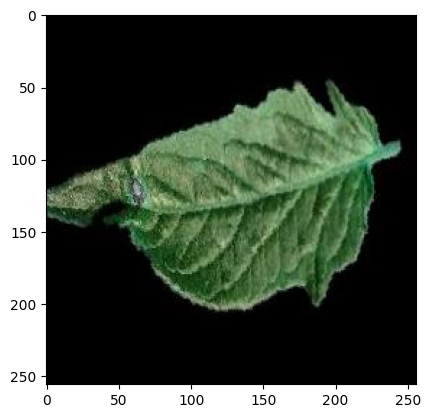

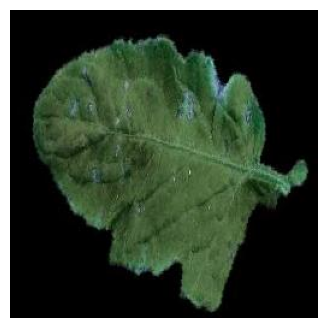

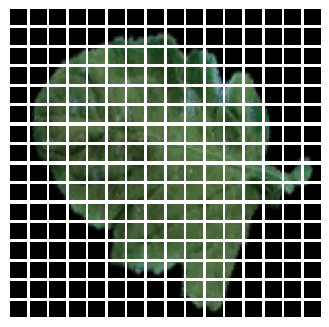

In [17]:
# v2 기반 스크립트

iter = 3

for idx_iter in range(iter):
    print('==========================================', idx_iter, 'idx_iter', '==========================================')

    # train_image_value = [] # x_train -> train_image_value
    # train_image_categ = [] # y_train -> train_image_categ
    # val_image_value = [] # x_val -> val_image_value
    # val_image_categ = [] # y_val -> val_image_categ
    # test_image_value = [] # x_test -> test_image_value
    # test_image_categ = [] # y_test -> test_image_categ


    # train/val/test set을 위한 변수
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    tmp = 0
    random_number_val = []
    random_number_test = []

    #####################################
    # train/val/test random number 추출 #
    #####################################


    # train/val/test random number 추출
    # image_all.classes_indices 2가지 종류에서 0: 정상, 1:병징
    for idx_categ in range(len(Tomato_Dataset_all.class_indices)):  # len(Tomato_Dataset_all.class_indices -> num_classes(Healthy, Disease) == rankge(2) == [0,1]

        # random_num_max = 각 폴더 내 사진의 전체 개수
        random_num_max = list(Tomato_Sample_info[:][0]).count(list(Tomato_Dataset_all.class_indices.keys())[idx_categ]) # idx_categ == 0 : Healthy , idx_categ == 1 : Disease
        print('정상, 병징 각 폴더 내 사진 전체 개수:', random_num_max)

        # random_num_max_val = testset 제외한(0.2, 20%) 사진의 전체 개수(즉 train & val 전체 개수 구함)
        random_num_max_val = math.floor(list(Tomato_Sample_info[:][0]).count(list(Tomato_Dataset_all.class_indices.keys())[idx_categ]) * (1 - Ratio_test_set))
            # math.ceil = 실수를 올림해 정수로 반환
            # math.floor = 실수를 내림해 정수로 반환
        print('정상, 병징 각 폴더 내 testset 제외 사진 전체 개수:', random_num_max_val)


        ####################################################################################
        ##################            Validation set 값들을 지정          ##################
        ####################################################################################

        # 0 이상 random_num_max_val 미만의 범위에서 Ratio_val_set(0.2, 20%) 만큼의 수를 랜덤하게 샘플링하라
        tmp_random_number_val = sample(range(0, random_num_max_val), math.ceil(random_num_max_val * Ratio_val_set)) # Ratio_val_set = 0.8 * 0.2 == 0.16
            # sample(컬렉션, 샘플수) : 지정된 컬렉션으로부터 샘플수만큼 리스트 형식으로 랜덤 추출하라
            # math.ceil(random_num_max_val * Ratio_val_set) : 전체에서 0.8의 train set에서 0.2의 val 추출
        print('random 추출한 validation 용 데이터 전체 개수:', len(tmp_random_number_val))


        ####################################################################################
        ##################             Test set 값들을 지정               ##################
        ####################################################################################
        # TESTset은 여러 input datset의 마지막 data들만 가져오므로 일정하다
        # tmp_random_number_test = test에 사용될 사진 개수
        tmp_random_number_test = list(range(random_num_max_val, random_num_max))
        print('전체 데이터 셋의 하위 20% 선별한 test용 데이터 전체 개수:', len(tmp_random_number_test))


        ####################################################################################
        ####  Validation, test set 값들을 실수 형식으로 누적 시켜 최종 리스트로 뽑는다  ####
        ####################################################################################
        # Validation set 값들을 실수 형식으로 누적시켜 하나의 리스트로 뽑는다
        random_number_val.extend(tmp_random_number_val + np.ones(shape=(len(tmp_random_number_val))) * tmp)

        # test set 값들을 실수 형식으로 누적시켜 하나의 리스트로 뽑는다
        random_number_test.extend(tmp_random_number_test + np.ones(shape=(len(tmp_random_number_test))) * tmp)

        # 각 폴더(Healthy, Disease 내에서의 번호가 아닌 전체 156개 사진에서의 번호 지정을 위함
        tmp = tmp + random_num_max

    # 파일명 저장을 위한 리스트 변수
        # map 함수 == map(함수, 반복 가능 자료형)의 형태를 가짐
        # list(map(int, random_number_val)) == 기존 float 형태이던 random_number_val을 int type으로 바꿔 list화
    val_set = [list(Tomato_Sample_info[:][1])[i] for i in list(map(int, random_number_val))]
    test_set = [list(Tomato_Sample_info[:][1])[i] for i in list(map(int, random_number_test))]
    test_set_new = []
    val_set_new = []

    
   
    # image sample을 random number에 기반하여 train/val/test split
    for idx_all_categ in range(len(Tomato_Dataset_all)):
        tmp = Tomato_Dataset_all.filenames[idx_all_categ].split("/")[1]
        tmp_value = cv2.imread(os.path.join(Tomato_dataset_path, Tomato_Dataset_all.filenames[idx_all_categ]))
        # 이전 스크립트: img_value = cv2.imread(Tomato_dataset_path + '/' + Tomato_Dataset_all.filenames[img_num])/255
        # print('reshape 이전 tmp_value:', tmp_value)

        tmp_value = tmp_value.reshape(1, tmp_value.shape[0], tmp_value.shape[1], tmp_value.shape[2])
            # {numpy.array}.shape == numpy.array가 어떤 모습 및 차원으로 구성되는지 보여줌
            # (1, 256, 256, 3) 형태로 reshape
        # print(tmp_value.shape) # (1, 256, 256, 3)

        tmp_categ = to_categorical(Tomato_Dataset_all.classes)[idx_all_categ]
            # to_categorical == 정수형 클래스 레이블을 원-핫 인코딩 벡터로 변환하는 함수
            # Tomato_Dataset_all.classes == 0, 1로 작물의 정상, 병징에 대한 category를 모두 정리해 둔 리스트
            # idx_all_categ == 전체 category의 index를 불러옴(110번째, 111번째 ,,,)
        # print('before reshape tmp_categ:', tmp_categ) # tmp_categ = [1. 0.] or [0. 1.]

        tmp_categ = tmp_categ.reshape(1, tmp_categ.shape[0])
        # print('after reshape tmp_categ:', tmp_categ) # (after reshape)tmp_categ == [[1. 0.]] of [[0. 1.]]
        # print('after reshape tmp_categ.shape', tmp_categ.shape) # (after reshape)tmp_categ.shape == (1,2)


        if tmp in val_set: # val_set == validation 이미지 파일명들 모아둔 리스트
            # if Tomato_Dataset_all.filenames[idx_all_categ].split("/")[1].split(".")[0] == '1':
                # 원본 leaf_classification에서는 조건이 있었던 것 같지만 현재는 없으므로 패스
            x_val.append(tmp_value)
            y_val.append(tmp_categ)
            val_set_new.append(tmp) # 왜 val_set_new에 새로 validation set을 만들지?

        elif tmp in test_set: # test_set == test 이미지 파일명들 모아둔" 리스트
            # if Tomato_Dataset_all.filenames[idx_all_categ].split("/")[1].split(".")[0] == '1':
                # 원본 leaf_classification에서는 조건이 있었던 것 같지만 현재는 없으므로 패스
            x_test.append(tmp_value)
            y_test.append(tmp_categ)
            test_set_new.append(tmp) # 왜 test_set_new에 새로 validation set을 만들지?

        else:
            x_train.append(tmp_value)
            y_train.append(tmp_categ) # 왜 test_set_new에 새로 validation set을 만들지?


    print(": Number of dataset(Train -", str(len(x_train)), "/Val -", str(len(val_set_new)), "/Test -", str(len(test_set_new)), ")")

    with tf.device('/GPU:0'): 
        # np.array(x_train).shape == (2518, 1, 256, 256, 3)
        x_train = np.array(x_train).reshape(np.array(x_train).shape[0], np.array(x_train).shape[2], np.array(x_train).shape[3], np.array(x_train).shape[4])
        y_train = np.array(y_train).reshape(np.array(y_train).shape[0], np.array(y_train).shape[2])
        x_val = np.array(x_val).reshape(np.array(x_val).shape[0], np.array(x_val).shape[2], np.array(x_val).shape[3], np.array(x_val).shape[4])
        y_val = np.array(y_val).reshape(np.array(y_val).shape[0], np.array(y_val).shape[2])
        x_test = np.array(x_test).reshape(np.array(x_test).shape[0], np.array(x_test).shape[2], np.array(x_test).shape[3], np.array(x_test).shape[4])
        y_test = np.array(y_test).reshape(np.array(y_test).shape[0], np.array(y_test).shape[2])

        print('x_train.shape:',x_train.shape)
        print('y_train.shape:',y_train.shape)
        print('x_val.shape:',x_val.shape)
        print('y_val.shape:',y_val.shape)
        print('x_test.shape:',x_test.shape)
        print('y_test.shape:',y_test.shape)

        print(": Success to split dataset")

    # np.argmax
    y_train = np.argmax(y_train, axis=1)
    y_val = np.argmax(y_val, axis=1)
    y_test = np.argmax(y_test, axis=1)
    print('np.argmax(y_train, axis =1):', y_train.shape)
    print('np.argmax(y_val, axis=1):', y_val.shape)
    print('np.argmax(y_test, axis=1):', y_test.shape)


    # result_pred_pd 생성
    result_pred_pd = pd.DataFrame(np.zeros(shape=(len(y_test), 2)))
    num_categ = len(Tomato_Dataset_all.class_indices)


    # 원본 data augmentation -> data resizing
    data_resizing = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size),
        ],
        name="data_resizing",
    )
    # Compute the mean and the variance of the training data for normalization.
    data_resizing.layers[0].adapt(x_train)
    print('data_resizing.layers[0].adapt(x_train):', data_resizing.layers[0].adapt(x_train))

    
    # v2기반 스크립트
    # Display patches for a sample image
    import matplotlib.pyplot as plt_imshow   

    plt_imshow.imshow(x_train[0])

    plt_imshow.figure(figsize=(4, 4))
    image = x_train[np.random.choice(range(x_train.shape[0]))]

    # 원본 스크립트
    # plt_imshow.imshow(image.astype("uint8")) # uint8 type으로 바꾸면 검은색 사진으로만 나옴
    plt_imshow.imshow(image.astype("uint8"))
    plt_imshow.axis("off")
    resized_image = tf.image.resize(
        tf.convert_to_tensor([image]), size=(image_size, image_size)
    )
    patches = Patches(patch_size)(resized_image)
    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt_imshow.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt_imshow.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt_imshow.imshow(patch_img.numpy().astype("uint8")) # unit8 type으로 바꾸면 검은색 사진으로만 나옴
        plt_imshow.axis("off")

    print('patch 크기',np.array(patch_img).shape)


    # 학습 수행
    vit_classifier = create_vit_classifier()
    history = run_experiment(vit_classifier)


# Accuracy, precision, recall, f1 score 구하고 excel 파일에 저장
result_acc_pd = pd.DataFrame(result_acc, columns=['ViT'])
result_val_acc_pd = pd.DataFrame(result_val_acc, columns=['ViT'])

result_acc_pd.to_excel(writer, sheet_name='summary_test_set')
result_val_acc_pd.to_excel(writer, sheet_name='summary_val_set')

result_precision_pd = pd.DataFrame(result_precision, columns=['ViT'])
result_recall_pd = pd.DataFrame(result_recall, columns=['ViT'])
result_f1_pd = pd.DataFrame(result_f1, columns=['ViT'])

result_precision_pd.to_excel(writer, sheet_name='Precision')
result_recall_pd.to_excel(writer, sheet_name='Recall')
result_f1_pd.to_excel(writer, sheet_name='f1 score')

writer.save()

print("------------------------------------------------------------------------")
print("------------------------------------------------------------------------")

### 모델 summary

In [27]:
vit_classifier.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_resizing (Sequential)     (None, 128, 128, 3)  7           ['input_7[0][0]']                
                                                                                                  
 patches_13 (Patches)           (None, None, 192)    0           ['data_resizing[0][0]']          
                                                                                                  
 patch_encoder_6 (PatchEncoder)  (None, 256, 64)     28736       ['patches_13[0][0]']       

                                                                                                  
 multi_head_attention_51 (Multi  (None, 256, 64)     66368       ['layer_normalization_108[0][0]',
 HeadAttention)                                                   'layer_normalization_108[0][0]']
                                                                                                  
 add_102 (Add)                  (None, 256, 64)      0           ['multi_head_attention_51[0][0]',
                                                                  'add_101[0][0]']                
                                                                                                  
 layer_normalization_109 (Layer  (None, 256, 64)     128         ['add_102[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 dense_127

 dense_134 (Dense)              (None, 256, 64)      8256        ['dropout_126[0][0]']            
                                                                                                  
 dropout_127 (Dropout)          (None, 256, 64)      0           ['dense_134[0][0]']              
                                                                                                  
 add_109 (Add)                  (None, 256, 64)      0           ['dropout_127[0][0]',            
                                                                  'add_108[0][0]']                
                                                                                                  
 layer_normalization_116 (Layer  (None, 256, 64)     128         ['add_109[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_hea